In [151]:
import fit
from espace import build_espace
from gf_lanczos import build_gf_lanczos
from lookup import get_sector_index, get_spin_indices

In [2]:
def lorentzian_function(gamma, z0):
    def inner(z):
        return 1/np.pi * (0.5*gamma) / ((z-z0)**2 + (0.5*gamma)**2)
    inner.z0 = z0
    inner.gamma = gamma
    return inner

In [3]:
lorentz = lorentzian_function(2*0.3, 0.)

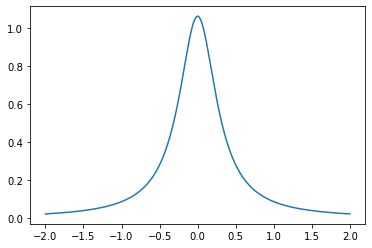

In [360]:
energies = np.arange(-2,2,1e-3)
plt.plot(energies, lorentz(energies))

In [361]:
n = 4
N = 10
M = n * N

def sample(p, rng, x0, n):
    z = rng * np.random.random(int(1e5)) - rng/2 - x0
    probs = p(z)
    probs /= probs.sum()
    poles = np.random.choice(z, n, p=probs)
    poles.sort()
    return poles

In [365]:
poles = sample(lorentz, 10., 0., n)

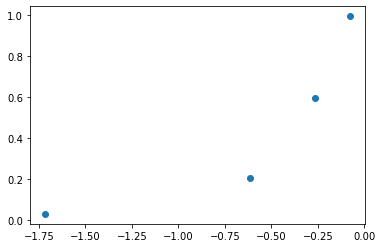

In [366]:
plt.plot(poles, lorentz(poles), 'o')

In [367]:
def build_gf0(poles):
    def gf0(z):
        z = np.array(z, ndmin=1)
        return 1/n * np.reciprocal(z[:,None]-poles[None,:]).sum(1)
    gf0.poles = poles
    gf0.n = poles.size
    return gf0

In [368]:
gf0 = build_gf0(poles)

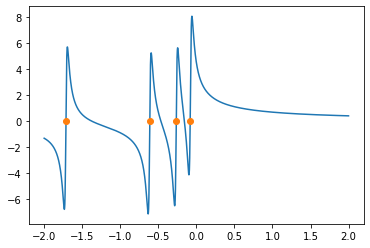

In [369]:
eta = 0.02
plt.plot(energies, gf0(energies+1.j*eta).real)
plt.plot(poles, np.zeros(poles.size), 'o')

In [401]:
from scipy.optimize import fsolve
from scipy.misc import derivative

def build_gfimp(gf0):
    poles = gf0.poles
    n = gf0.n
    ek = np.zeros(n-1)
    vk2 = np.zeros(n-1)
    for i in range(n-1):
        ek[i] = fsolve(gf0, (poles[i+1]+poles[i])/2)
        vk2[i] = -1/derivative(gf0, ek[i], dx=1e-6)
    e0 = poles.mean()
    def gfimp(z):
        z = np.array(z, ndmin=1)
        delta = lambda z: vk2[None,:] * np.reciprocal(z[:,None]-ek[None,:])
        return np.reciprocal(z[:,None]-e0-delta(z)).sum(1)
    gfimp.e0 = e0
    gfimp.ek = ek
    gfimp.vk2 = vk2
    return gfimp

In [403]:
gfimp = build_gfimp(gf0)

In [240]:
H = np.zeros((n,n))
V = np.zeros((n,n))

def build_H(H, V, e0, U, ek, vk):
    n = H.shape[0]
    H[1:,0] = H[0,1:] = vk
    H.flat[(n+1)::(n+1)] = ek
    H[0,0] = e0
    V[0,0] = U
    
vk = np.square(gfimp.vk2)
build_H(H, V, gfimp.e0, 0., gfimp.ek, -vk)

In [293]:
neig = np.ones((n+1)*(n+1)) * 1
espace, egs = build_espace(H, V, neig)

In [294]:
def keep_gs(espace, egs):
    delete = []
    for (nup, ndw), sct in espace.items():
        diff = np.abs(sct.eigvals-egs) < 1e-7
        if ~diff.any():
            delete.append((nup,ndw))
    for k in delete:
        espace.pop(k)

In [295]:
keep_gs(espace, egs)

In [299]:
gf0imp = build_gf_lanczos(H, V, espace, 0.)

In [498]:
from numba import njit

@njit()
def get_occupation(vector, states_up, states_dw):
    N = 0.
    occps = vector**2
    d = states_up.size*states_dw.size
    dup = states_up.size
    dwn = states_dw.size
    
    for i in range(d):
        iup = i%dup
        idw = i//dup
        sup = states_up[iup]
        sdw = states_dw[idw]
        for j in range(0,n):
            if (sup>>j)&np.uint32(1):
                N += occps[i]
            if (sdw>>j)&np.uint32(1):
                N += occps[i]      
    return N

In [534]:
from shared import params
params['hfmode'] = False

n = 4
N = int(5e4)
M = n * N
H = np.zeros((n,n))
V = np.zeros((n,n))
U = 3.
eta = 0.02
w = energies + 1.j*eta*energies

In [547]:
sigma = np.zeros_like(w)

In [551]:
count = 0
for _ in progressbar.progressbar(range(N)):
    found = False
    while not found:
        poles = sample(lorentz, 10., 0., n)
        gf0 = build_gf0(poles)
        gfimp = build_gfimp(gf0)
        vk = np.square(np.abs(gfimp.vk2))
        V[0,0]
        build_H(H, V, gfimp.e0, 0., gfimp.ek, -vk)
        neig = np.ones((n+1)*(n+1)) * 1
        espace, egs = build_espace(H, V, neig)
        keep_gs(espace, egs)
        sct = next(v for v in espace.values())
        evec = sct.eigvecs[:,0] if sct.eigvecs.ndim == 2 else sct.eigvecs 
        N0 = get_occupation(evec,sct.states.up,sct.states.dw)
        V[0,0] = U
        H[0,0] -= U/2
        espace, egs = build_espace(H, V, neig)
        keep_gs(espace, egs)
        sct = next(v for v in espace.values())
        evec = sct.eigvecs[:,0] if sct.eigvecs.ndim == 2 else sct.eigvecs 
        Nv = get_occupation(evec,sct.states.up,sct.states.dw)
        if np.allclose(Nv,N0):
            try:
                gf = build_gf_lanczos(H, V, espace, 0.)
            except:
                continue
            sigma += np.reciprocal(np.reciprocal(gf0(w))-gf(energies,1.j*eta*energies))
            found = True

  0% (280 of 50000) |                    | Elapsed Time: 0:02:46 ETA:   9:51:09/home/gag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in reciprocal
  after removing the cwd from sys.path.
 63% (31709 of 50000) |###########       | Elapsed Time: 5:03:39 ETA:   2:46:23

KeyboardInterrupt: 

/home/gag/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


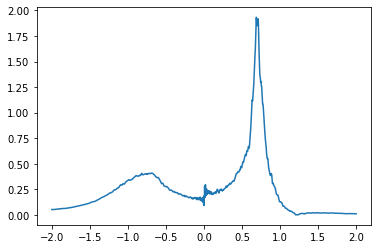

In [556]:
gf = 1/(w-sigma/(v+1)-0.3j)
plt.plot(w,np.abs(-1/np.pi*gf.imag))

In [553]:
v=31709